In [1]:
import argparse
import matplotlib.pyplot as plt
from multibio_model import MultiBio



In [2]:
def main(test_input):
    parser = argparse.ArgumentParser(description='Learning with LM-LSTM-CRF together with Language Model')
    parser.add_argument('--rand_embedding', action='store_true', default= False, help='random initialize word embedding')
    parser.add_argument('--emb_file', default='data_bioner_5/source.txt', help='path to pre-trained embedding')
    parser.add_argument('--train_file', nargs='+', default=[ "data_bioner_5/BC4CHEMD-IOBES/train"],
                        help='path to training file')
    parser.add_argument('--dev_file', nargs='+', default=[ "data_bioner_5/BC4CHEMD-IOBES/devel"],
                        help='path to development file')
    parser.add_argument('--test_file', nargs='+', default=[ "data_bioner_5/BC4CHEMD-IOBES/test"],
                        help='path to test file')
    parser.add_argument('--gpu', type=int, default=-1, help='gpu id')
    parser.add_argument('--batch_size', type=int, default=40, help='batch_size')
    parser.add_argument('--unk', default='unk', help='unknow-token in pre-trained embedding')
    parser.add_argument('--char_hidden', type=int, default=300, help='dimension of char-level layers')
    parser.add_argument('--word_hidden', type=int, default=300, help='dimension of word-level layers')
    parser.add_argument('--drop_out', type=float, default=0.5, help='dropout ratio')
    parser.add_argument('--epoch', type=int, default=1, help='maximum epoch number')
    parser.add_argument('--start_epoch', type=int, default=0, help='start point of epoch')
    parser.add_argument('--checkpoint', default='./checkpoint/', help='checkpoint path')
    parser.add_argument('--caseless', action='store_true', default=True, help='caseless or not')
    parser.add_argument('--char_dim', type=int, default=30, help='dimension of char embedding')
    parser.add_argument('--word_dim', type=int, default=50, help='dimension of word embedding')
    parser.add_argument('--char_layers', type=int, default=1, help='number of char level layers')
    parser.add_argument('--word_layers', type=int, default=1, help='number of word level layers')
    parser.add_argument('--lr', type=float, default=0.01, help='initial learning rate')
    parser.add_argument('--lr_decay', type=float, default=0.05, help='decay ratio of learning rate')
    parser.add_argument('--fine_tune', action='store_false', default=True, help='fine tune the diction of word embedding or not')
    parser.add_argument('--load_check_point', default=False, help='path previous checkpoint that want to be loaded')
    parser.add_argument('--load_opt', action='store_true', default=False, help='also load optimizer from the checkpoint')
    parser.add_argument('--update', choices=['sgd', 'adam'], default='sgd', help='optimizer choice')
    parser.add_argument('--momentum', type=float, default=0.9, help='momentum for sgd')
    parser.add_argument('--clip_grad', type=float, default=5.0, help='clip grad at')
    parser.add_argument('--small_crf', action='store_false', default=True,
                        help='use small crf instead of large crf, refer model.crf module for more details')
    parser.add_argument('--mini_count', type=float, default=5, help='thresholds to replace rare words with <unk>')
    parser.add_argument('--lambda0', type=float, default=1, help='lambda0')
    parser.add_argument('--co_train', action='store_true', default=False, help='cotrain language model')
    parser.add_argument('--patience', type=int, default=50, help='patience for early stop')
    parser.add_argument('--high_way', action='store_true', default=False, help='use highway layers')
    parser.add_argument('--highway_layers', type=int, default=1, help='number of highway layers')
    parser.add_argument('--eva_matrix', choices=['a', 'fa'], default='fa', help='use f1 and accuracy or accuracy alone')
    parser.add_argument('--least_iters', type=int, default=50, help='at least train how many epochs before stop')
    parser.add_argument('--shrink_embedding', action='store_true', default=True,
                        help='shrink the embedding dictionary to corpus (open this if pre-trained embedding dictionary is too large, but disable this may yield better results on external corpus)')
    parser.add_argument('--output_annotation', action='store_true', default=True, help='output annotation results or not')
    parser.add_argument('--output_file', default='annotate/output', help='path to output file')
    args = parser.parse_args(args=[])
    model = MultiBio(args)
    model.read_dataset(None, None)
    model.build_model()
    loss_list, acc_list = model.train(None)

    plt.subplot(2, 1, 1)
    plt.title('Training loss')
    # loss_hist_ = loss_hist[1::100]  # sparse the curve a bit
    plt.plot(loss_list, '-o')
    plt.xlim(0,5)
    plt.xlabel('Epoch')

    plt.subplot(2, 1, 2)
    plt.title('Accuracy')
    plt.plot(acc_list, '-o', label='Training')
    plt.xlabel('Epoch')
    plt.axis([0, 5, 0, 100])
    plt.legend(loc='lower right')
    # plt.gcf().set_size_inches(15, 12)
    #plt.savefig('BC2GM-IOBES.png')
    plt.show(block=False)
    
    out_path = model.predict(None, None, None)
    test_f1, test_pre, test_rec, test_acc = model.evaluate(None, None, None, None)
    print("Test evaluation: f1 = %.4f, recall = %.4f, precision = %.4f " % (test_f1, test_rec, test_pre))

    parser = argparse.ArgumentParser(description='Evaluating LM-BLSTM-CRF')
    parser.add_argument('--load_arg', default='./checkpoint/cwlm_lstm_crf.json', help='path to arg json')
    parser.add_argument('--load_check_point', default='./checkpoint/cwlm_lstm_crf.model',
                        help='path to model checkpoint file')
    parser.add_argument('--gpu', type=int, default=-1, help='gpu id')
    parser.add_argument('--decode_type', choices=['label', 'string'], default='label',
                        help='type of decode function, set `label` to couple label with text, or set `string` to insert label into test')
    parser.add_argument('--batch_size', type=int, default=50, help='size of batch')
    parser.add_argument('--eva_matrix', choices=['a', 'fa'], default='fa',
                        help='use f1 and accuracy or accuracy alone')
    parser.add_argument('--input_file', default=test_input, help='path to input un-annotated corpus')
    parser.add_argument('--output_file', default='annotate/output', help='path to output file')
    parser.add_argument('--dataset_no', type=int, default=1, help='number of the datasets')
    args = parser.parse_args(args=[])
    out_path = model.load_model(args)
    return out_path


setting:

Namespace(batch_size=40, caseless=True, char_dim=30, char_hidden=300, char_layers=1, checkpoint='./checkpoint/', clip_grad=5.0, co_train=False, dev_file=['data_bioner_5/BC4CHEMD-IOBES/devel'], drop_out=0.5, emb_file='data_bioner_5/source.txt', epoch=1, eva_matrix='fa', fine_tune=True, gpu=-1, high_way=False, highway_layers=1, lambda0=1, least_iters=50, load_check_point=False, load_opt=False, lr=0.01, lr_decay=0.05, mini_count=5, momentum=0.9, output_annotation=True, output_file='annotate/output', patience=50, rand_embedding=False, shrink_embedding=True, small_crf=True, start_epoch=0, test_file=['data_bioner_5/BC4CHEMD-IOBES/test'], train_file=['data_bioner_5/BC4CHEMD-IOBES/train'], unk='unk', update='sgd', word_dim=50, word_hidden=300, word_layers=1)

loading corpus

constructing coding table

feature size: '68'

loading embedding

embedding size: '1421'

constructing dataset

building model

 - Tot it 4 (epoch 0):   0%|          | 0/1 [00:00<?, ?it/s]

 - Tot it 4 (epoch 0): 100%|██████████| 1/1 [00:08<00:00,  8.50s/it]

(loss: 40.4501, epoch: 0, dataset: 0, dev F1 = 0.0000, dev pre = 0.0000, dev rec = 0.0000)

epoch: 0	 in 1 take: 11.036799669265747 s

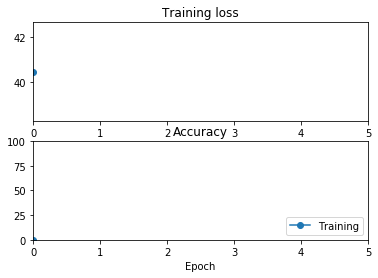

 - Process:   0%|          | 0/1 [00:00<?, ?it/s]

 - Process: 100%|██████████| 1/1 [00:02<00:00,  2.40s/it]

Test evaluation: f1 = 0.0000, recall = 0.0000, precision = 0.0000 

CSCI548 model loading

loading dictionary

loading model

loading corpus

annotating the entity type

0

 - Process:   0%|          | 0/1 [00:00<?, ?it/s]

 - Process:   0%|          | 0/1 [00:00<?, ?it/s]

 - Process:   0%|          | 0/1 [00:00<?, ?it/s]

 - Process:   0%|          | 0/1 [00:00<?, ?it/s]

 - Process:   0%|          | 0/1 [00:00<?, ?it/s]

 - Process:   0%|          | 0/1 [00:00<?, ?it/s]

 - Process:   0%|          | 0/1 [00:00<?, ?it/s]

 - Process:   0%|          | 0/1 [00:00<?, ?it/s]

 - Process:   0%|          | 0/1 [00:00<?, ?it/s]

Test evaluation: f1 = 0.0000, recall = 0.0000, precision = 0.0000 

annotate/output0.txt

In [4]:
if __name__ == "__main__":
    test_input_path = "tests/ner_test_input.txt"
    out_path = main(test_input_path)
    print(out_path)